# Mixture of Experts(MoE)

In [ ]:
#|default_exp moe

In [ ]:
#|export
import math, torch, torch.nn.functional as F
from torch import nn
from fastai.vision.all import *

In [ ]:
#|hide
import torchvision.transforms as T
import matplotlib as mpl, matplotlib.pyplot as plt
import torch.optim as optim
from fastai.vision.all import *
from torchvision.datasets import MNIST
from FastFF.performance import *
from functools import wraps
import wandb
from fastai.callback.wandb import *

In [ ]:
#|hide
set_seed(0)
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: slakter. Use `wandb login --relogin` to force relogin


True

In [ ]:
#|export
def lin(in_dim, out_dim, act=nn.ReLU, bias=True):
    '''Linear layer followed by activation'''
    if act is None: act = nn.Identity
    return nn.Sequential(nn.Linear(in_dim, out_dim, bias), act())

def mlp(in_dim, out_dim, hidden_dim=128, n_hidden=1, act=nn.ReLU, bias=True):
    '''Multilayer perceptron with several hidden layers'''
    if n_hidden==0: return lin(in_dim, out_dim, act, bias)
    res = nn.Sequential(*lin(in_dim, hidden_dim, act, bias))
    for _ in range(n_hidden-1): res+= lin(hidden_dim, hidden_dim, act, bias)
    res += lin(hidden_dim, out_dim, act, bias)
    return res

In [ ]:
#|export
# benchmark comparing nn.ModuleList and nn.Conv1d https://discuss.pytorch.org/t/parallel-execution-of-modules-in-nn-modulelist/43940/11
class Experts(nn.ModuleList):
    """A class representing a collection of experts. Will compute weighted sum of results of topk experts depending on `selected_exps`"""
    
    def forward(self, x, routing_ws, selected_exps):
        mask = F.one_hot(selected_exps, num_classes=len(self)).permute(2, 1, 0)
        for i in range(len(self)):
            idx, top_x = torch.where(mask[i])
            if top_x.shape[0] == 0: continue
            # in torch it is faster to index using lists than torch tensors
            top_x_list = top_x.tolist()
            res = self[i](x[top_x_list]) * routing_ws[top_x_list, idx.tolist(), None]
            if 'out' not in locals(): out = torch.zeros((x.shape[0],*res.shape[1:]), device=x.device)
            out.index_add_(0, top_x, res)
        return out


class MoE(nn.Module):
    '''Mixture of experts network'''
    def __init__(self, in_dim, out_dim, n_experts=4, top_k=4, hidden_dim=128, act=nn.ReLU):
        super().__init__()
        store_attr()
        self.gate = lin(in_dim, n_experts, act=act, bias=False)
        self.experts = Experts(mlp(in_dim,out_dim, hidden_dim, act=act) for _ in range(n_experts))
    
    def forward(self,x):
        logits = self.gate(x)
        routing_weights = F.softmax(logits, dim=1)
        self.routing_weights = routing_weights
        routing_weights, selected_exps = torch.topk(routing_weights, self.top_k, dim=-1)
        routing_weights /= routing_weights.sum(dim=-1, keepdim=True)
        return self.experts(x, routing_weights, selected_exps)

In [ ]:
#|export
class FFF(MoE):
    def __init__(self, in_dim, out_dim, depth=2, top_k=4, hidden_dim = 128, act=nn.ReLU):
        store_attr()
        self.n_leaves = 2**depth
        super().__init__(in_dim, out_dim, self.n_leaves, top_k, hidden_dim, act)
        # override gate to have size 1 less
        self.gate = lin(in_dim, self.n_leaves-1, act=act, bias=False)
    
    def forward(self, x):
        bs = x.shape[0]
        logits = self.gate(x)
        logprobs = F.logsigmoid(torch.stack([-logits, logits],dim=2))     # (bs, n_leaves-1, 2)
        leaf_distr = torch.zeros([bs,self.n_leaves], device=x.device)     # (bs, n_leaves)
        for d in range(self.depth):
            mask = logprobs[:, 2**d-1 : 2**(d+1)-1].view(bs,-1, 1)        # (bs, 2*2**d, 1)
            leaf_distr = leaf_distr.view(bs, 2**(d+1), -1) + mask         # (bs, 2**(d+1), n_leaves//2**(d+1) )
        leaf_distr = torch.exp(leaf_distr).view(bs, -1)
        self.leaf_distr = leaf_distr.detach()
        routing_weights, selected_exps = torch.topk(leaf_distr, self.top_k, dim=-1)
        return self.experts(x, routing_weights, selected_exps)

In [ ]:
#|export
class InitFFF(MoE):
    def __init__(self, in_dim, out_dim, depth=2, top_k=4, hidden_dim = 128, act=nn.ReLU):
        store_attr()
        self.n_leaves = 2**depth
        self.tree = self.init_tree_()
        super().__init__(in_dim, out_dim, self.n_leaves, top_k, hidden_dim, act)
        # override gate to have size 1 less
        self.gate = lin(in_dim, self.n_leaves-1, act=act, bias=False)
    
    def init_tree_(self):
        masks = [torch.eye(self.n_leaves)]
        for _ in range(self.depth-1): masks.append(masks[-1].view(-1, 2, self.n_leaves).sum(1))
        return torch.cat(list(reversed(masks)),dim=0)   # (2*n_leaves-2, n_leaves)
    
    def forward(self, x):
        bs = x.shape[0]
        logits = self.gate(x)
        logprobs = F.logsigmoid(torch.stack([-logits, logits],dim=2).view(bs,-1))     # (bs, 2*n_leaves-2)
        leaf_distr = torch.exp(torch.matmul(logprobs, self.tree))
        self.leaf_distr = leaf_distr.detach()
        routing_weights, selected_exps = torch.topk(leaf_distr, self.top_k, dim=-1)
        return self.experts(x, routing_weights, selected_exps)

In [ ]:
#|hide
#|eval: false

n=4
h=64
topk=4
bs = 512 

model = MoE(28*28, 10, n, topk, hidden_dim=h)
ds = get_mnist_ds()
cbs = [GetGradCB([model.experts[0][0]]), ShowGraphCallback()]
dls = DataLoaders(TfmdDL(ds[0], bs, True),TfmdDL(ds[1], bs, False))
learn = Learner(dls, model, loss_func=F.cross_entropy, metrics=accuracy, opt_func = Adam)

In [ ]:
learn.fit_one_cycle(15, lr_max=4e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.642503,0.299578,0.913800,00:14
1,0.258853,0.185443,0.944100,00:12
2,0.166853,0.166852,0.951000,00:12
3,0.119807,0.123841,0.963700,00:11
4,0.094167,0.112666,0.965300,00:13
5,0.071150,0.121141,0.964400,00:12
6,0.057223,0.101072,0.971700,00:14
7,0.046907,0.096758,0.973100,00:13
8,0.033667,0.096827,0.973200,00:13
9,0.022518,0.090585,0.975100,00:16


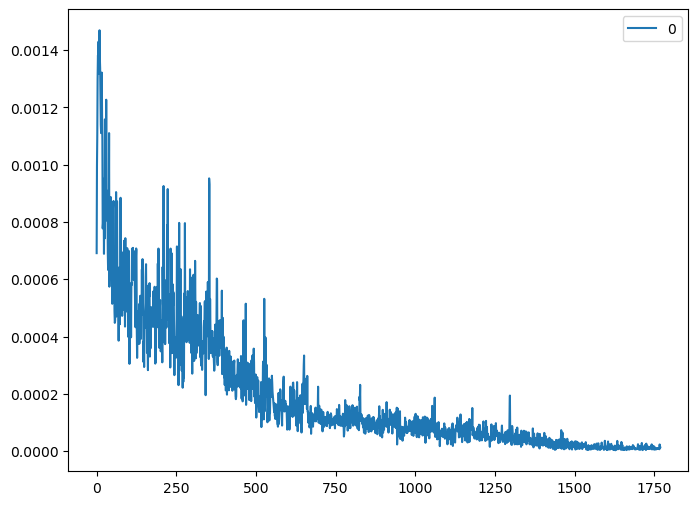

In [ ]:
#|eval: false
cbs[1].show(model.experts[0][0], lambda x: x.abs().mean((1,2))[:,None])

In [ ]:
#|hide
#|eval: false
d, l = 2, 64
topk = 4

model = FFF(28*28, 10, d, topk, hidden_dim=l)
cbs = [FFFLeavesDistCB('leaf_distr'), GetGradCB(['weight'], model.gate[0]), ShowGraphCallback()]
learn = Learner(dls, model, loss_func=F.cross_entropy, metrics=accuracy, opt_func = Adam, cbs=cbs)

epoch,train_loss,valid_loss,accuracy,time
0,0.540402,0.268098,0.922300,00:21
1,0.228258,0.172096,0.949400,00:21
2,0.149986,0.134052,0.954900,00:20
3,0.110361,0.093774,0.970900,00:21
4,0.083525,0.101393,0.971200,00:23
5,0.066644,0.091127,0.973600,00:25
6,0.050835,0.094991,0.974000,00:27
7,0.038467,0.081133,0.977600,00:24
8,0.026558,0.087659,0.977300,00:23
9,0.018021,0.078524,0.978900,00:30


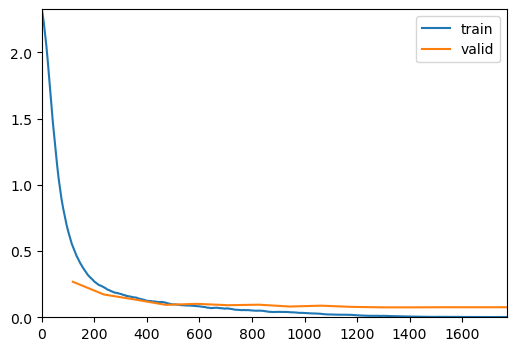

In [ ]:
#|eval: false
learn.fit_one_cycle(15, lr_max=7e-3);

## Run sweep

In [ ]:
def run_sweep(train_ds, test_ds, prm_model,sweep_cfg,
              metrics = accuracy,
              loss = F.cross_entropy,
              opt = Adam,
              cfg = None,
              before_learn_cb=None,
              after_learn_cb = None,
              project=None, count=5, seed=0):
    def _f(cfg=cfg):
        with wandb.init(config=cfg):
            if seed is not None: set_seed(seed)
            cfg = wandb.config
            model = prm_model(**cfg.model)
            dls = DataLoaders(TfmdDL(train_ds, cfg.bs, True,0 ),TfmdDL(test_ds, cfg.bs, False, 0 ))
            learn = Learner(dls, model, loss_func=loss, metrics=metrics, opt_func = opt)
            if before_learn_cb: before_learn_cb(learn, model, dls)
            learn.fit_one_cycle(cfg.epochs, **cfg.learn)
            if after_learn_cb: after_learn_cb(learn, model, dls)
    
    sweep_id = wandb.sweep(sweep_cfg, project=project)
    wandb.agent(sweep_id, _f, count=count)

In [ ]:
sweep_cfg = {
    'name': 'moe',
    'method': 'random',
    'metric':{'name': 'valid_loss','goal':'minimize'},
    'parameters':{
        'bs': {'value': 512},
        'learn':{'parameters':{'lr_max': {'value':4e-3}}},
        'model':{'parameters':{
            'h': {'value': 64},
            'd': {'value': 3},
            'mtype': {'values': ['FFF', 'MOE']},
            'topk': {'values': [1,2,3,4,5,6,7,8]}
            }},
        'epochs': {'value': 10}
    }
}

def get_model(mtype, d, h, topk):
    topk = min(topk, 2**d)
    if mtype=='FFF':
        return InitFFF(28*28, 10, d, topk, h)
    if mtype=='MOE':
        return MoE(28*28, 10, 2**d, topk, h)

def before_learn(learn, model, dls):
    model.n_leaves = model.n_experts
    attr = 'routing_weights' if type(model) == MoE else 'leaf_distr'
    learn.add_cbs([FFFLeavesDistCB(attr, wandb = True, sample_size=100), WandbCallback(log_preds=False)])

def after_learn(learn, model, dls):
    wandb.log({'topk_k':model.top_k})

In [ ]:
run_sweep(*get_mnist_ds(), get_model, sweep_cfg, before_learn_cb=before_learn, after_learn_cb=after_learn, project="FFF", count=10)